In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [3]:
#Enter the file path
path = './ScriptRuns/lows16version10_lows1.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [4]:
def Sort(sub_li): 
    l = len(sub_li) 
    for i in range(0, l): 
        for j in range(0, l-i-1): 
            if (sub_li[j][1] > sub_li[j + 1][1]): 
                tempo = sub_li[j] 
                sub_li[j]= sub_li[j + 1] 
                sub_li[j + 1]= tempo 
    return sub_li 

In [5]:
#linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
#SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)

In [13]:
linkRates = pd.read_csv('input_file_version10.csv',index_col=[0])
linkRates

,layer,MB,type,lpGBTs,eventSize,lpgbt_id,doublelpGBT
0,1,0,0,"[0, 1]",323.5744,0,True
1,1,1,0,[2],217.0022,2,False
2,1,2,0,"[3, 4]",364.5350,3,True
3,1,3,0,"[5, 6]",300.3104,5,True
4,1,4,1,[7],111.7748,7,False
...,...,...,...,...,...,...,...
1147,47,0,11,[2163],15.9518,2163,False
1148,47,0,11,[2164],16.1394,2164,False
1149,47,0,11,[2165],16.0978,2165,False
1150,47,0,11,[2166],16.0136,2166,False


In [14]:
linkRates.rename(columns = {'eventSize':'EvSize', 'doublelpGBT':'doubleDAQlpGBT',"lpgbt_id":"DAQlpGBT"}, inplace = True)
linkRates

,layer,MB,type,lpGBTs,EvSize,DAQlpGBT,doubleDAQlpGBT
0,1,0,0,"[0, 1]",323.5744,0,True
1,1,1,0,[2],217.0022,2,False
2,1,2,0,"[3, 4]",364.5350,3,True
3,1,3,0,"[5, 6]",300.3104,5,True
4,1,4,1,[7],111.7748,7,False
...,...,...,...,...,...,...,...
1147,47,0,11,[2163],15.9518,2163,False
1148,47,0,11,[2164],16.1394,2164,False
1149,47,0,11,[2165],16.0978,2165,False
1150,47,0,11,[2166],16.0136,2166,False


In [15]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")


sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
pd.set_option('display.max_rows', 10)
SizeSortedRates



There is a total of 1240 lpGBT links:
 - 1064 singles, and
 - 88 doubles (with one ECOND straddling the pair)



,layer,MB,type,lpGBTs,EvSize,DAQlpGBT,doubleDAQlpGBT
1017,36,0,4,[2033],9.3722,2033,False
1011,36,0,4,[2027],9.3722,2027,False
1013,36,0,4,[2029],9.4092,2029,False
1008,36,0,4,[2024],9.4132,2024,False
1010,36,0,4,[2026],9.4256,2026,False
...,...,...,...,...,...,...,...
87,4,102,0,"[109, 110]",417.7118,109,True
48,3,2,0,"[61, 62]",447.8950,61,True
62,3,102,0,"[78, 79]",448.2116,78,True
98,5,2,0,"[123, 124]",449.7524,123,True


In [16]:
def SwapModule(slinks,SlinkAve,L1,L2):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    print(ss)
    print("-------------OK--------------")
    m = np.array(ss)
    print(m.shape) #[192,2] boyutlu array çünkü 192 slink var
    #ilk eleman (string): slink ID, 
    #sonraki elemanın (array) ilk elemanı: o slink'e bağlı lpgbt'lerin data rate'lerinin toplamı,
    #sonraki çift elemanlar sırası ile lpgbt'nin ID'si ve onun data rate'i
    print("-------------OK--------------")
    lowC=-1
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        print('difference between high and low:', dif) #yeni
        temp=100000000
        flag=0
        for l in slinkHigh[1][1]: #loop on assigned lpgbt rates
            if abs((dif/2)-float(l[1])) < temp and dif > float(l[1]):
                lp=l[0] #lpgbt id l[1] lpgbt rate
                temp=abs((dif/2)-float(l[1]))
                flag=1
        #lp=Sort(slinkHigh[1][1])[0][0]
    
        if flag==1:
            for ilist,var in zip(L1,L2): #L1 sanırım lpgbt ID'leri ve L2 de onların bulunduğu adresler
                if str(lp) in ilist:
                    var[str(lp),slinkHigh[0]].value=0 #str(lp) swaplanacak lpgbt'nin ID'si, bu lpgbt ile slinkHigh bağlantısı koptu
                    var[str(lp),slinkLow[0]].value=1 #slinkLow bağlantısı sağlandı
                else:
                    continue
            lowC-=1
            print("-------------OK--------------")
        print("-----------------------------")

In [17]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])
#print(Vars)
#print(Slink)


In [18]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

In [19]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 602.6640729166666
Std:  16.343306479057535
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 16.343306479057535


In [20]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

SwapModule(swapData(),GKavSlinkRate,L1,L2)

[('12', [699.7962, [[254, 118.55559999999998], [494, 242.5558], [968, 60.19540000000001], [612, 61.995000000000005], [165, 84.2864], [2140, 16.3268], [626, 57.2596], [778, 58.6216]]]), ('107', [674.0666000000001, [[311, 108.3922], [480, 145.809], [43, 173.02280000000002], [511, 78.14519999999999], [2117, 14.198], [676, 42.3894], [990, 53.4234], [788, 58.686600000000006]]]), ('1', [657.069, [[460, 88.5614], [266, 121.4178], [546, 230.9244], [648, 67.03399999999999], [2018, 10.0256], [2110, 14.169], [2102, 14.9644], [2092, 15.8886], [816, 39.3452], [650, 54.7386]]]), ('106', [651.1378, [[326, 108.4636], [467, 145.2762], [57, 173.0408], [419, 73.275], [73, 82.6768], [2095, 15.7812], [1030, 52.6242]]]), ('109', [650.3528, [[796, 104.8584], [15, 322.9936], [510, 67.0524], [491, 80.5158], [2129, 16.9132], [578, 58.01939999999999]]]), ('182', [648.3925999999999, [[89, 88.8086], [161, 125.8588], [184, 224.53160000000003], [832, 62.290400000000005], [2143, 16.2896], [1016, 42.6956], [1045, 36.9

<ipython-input-16-d18118808a91>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = np.array(ss)


In [21]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 602.6640729166666
Std:  9.060937521814942
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 9.060937521814942


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


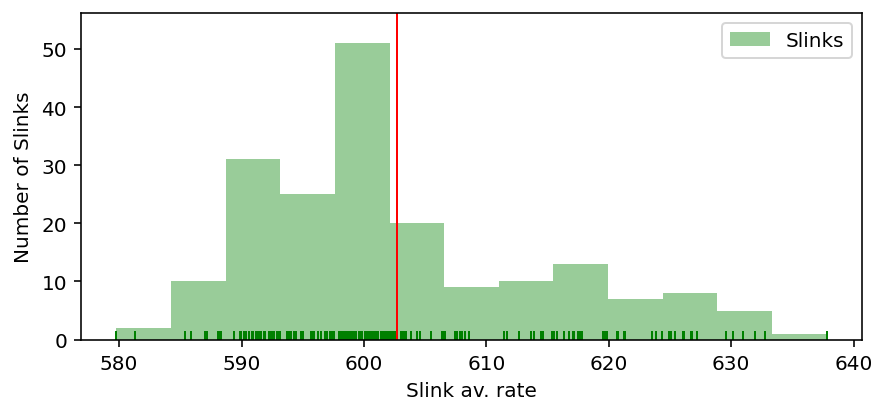

In [22]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
plt.savefig('Before_Swap.png')

In [23]:
FPGA=[]
Slink=[]
for i in range(1,17):
    FPGA.append(str(i))
for i in range(1,193):
    Slink.append(str(i))

    

In [24]:
GK2={}
#for j in FPGA:
    #GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])
for j in FPGA:
    sum=0
    for i in Slink:
        if model.GKSlinks[i, j].value==1:
            sum+=slink_rate_dict[i]
    GK2[j]=sum
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
fpga_rate_list



NameError: name 'slink_rate_dict' is not defined

In [ ]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')
plt.savefig("FPGA rate plot.png")

In [26]:
#BETTER ONE#
def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    
    if tester :
        check_list = [] #Birden fazla kere SwapModule2'yi cagirdigimizda ayni Slink'i iki kere process edip etmedigini test etmek icin bir list
        total_data = 0 #Data kaybi olup olmadigini kontrol etmek icin (153.692,76067... olmali)
        lpgbt_limit = 12 #Max lpgbt per Slink
        lpgbt_count = 0
        max_lpgbt = 0

        #for i in ss:
           # if i[0] not in check_list:
                #check_list.append(i[0])
               # total_data += i[1][0]
              #  lpgbt_count = len(i[1][1])
              #  if lpgbt_count > lpgbt_limit:
                #    print("Max lpgbt count per Slink is ", lpgbt_limit)
               # if lpgbt_count > max_lpgbt:
             #       max_lpgbt = lpgbt_count
           # else:
               # print("Slink is already present in the list")

        #print("Slink List is: ", check_list)
        #print("Length of the Slink List is: ", len(check_list))
        #print("Total data rate is: ", total_data)
        #print("Maximum number of lpgbt in an Slink is: ", max_lpgbt)

        lowC=-1
        highC=0
        #temp_low=lowC
        #print(ss)
        #print("OK------------------------------------")
        for i in ss: # i -- slink id s
            if len(i[1][1])==1:
                continue

            slinkHigh=ss[highC] #[çünkü ss high göre sort edilmiş slink dict]
            slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
            sub_li=[]
            sorted_sub_li=[]

            #print("HIGH: ", slinkHigh)
            #print("AND------------------------------------")
            #print("LOW", slinkLow)
            dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
            temp=0
            flag=0
            temp_best=1000000
            #for s in ss:
                #if s!=slinkHigh:
                #slinkLow=s
            for l in slinkHigh[1][1]:

                    #print(l)
                for k in slinkLow[1][1]:

                    if abs(float(l[1])-float(k[1]))<dif/2 and float(l[1])>float(k[1]): #and abs(GKavSlinkRate-abs(float(l[1])-float(k[1])))<temp_best:
                        #temp_best=abs(GKavSlinkRate-abs(float(l[1])-float(k[1]))
                            #temp=abs(float(l[1])-float(k[1]))
                        lphigh=l[0]
                        lplow=k[0]
                        flag=1
                    else:
                        continue
            if flag==0:
                lowC-=1

                #lowC-=1
                #slinkLow=ss[lowC]
            if flag==1:
                #lowC=temp_low
                highC+=1
                lowC-=1                      
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lphigh) in ilist: #and str(lplow)
                        var[str(lphigh),slinkHigh[0]].value=0
                        var[str(lphigh),slinkLow[0]].value=1

                for ilist,var in zip(L1_Swap,L2_Swap): #yeni- Bu for loop diger loop'un icindeydi ve ayni islemi tekrar tekrar yapiyordu.
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                        #print(str(lphigh))
                        #print(str(lplow))
                    #elif str(lplow) in ilist:
                        #var[str(lplow),slinkLow[0]].value=0
                        #var[str(lplow),slinkHigh[0]].value=1

                #ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
                #print("-------------OK--------------")
            #print("-----------------------------")
            #lowC-=1


In [27]:
##### SWAP #######
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [30]:
L1_Swap=[]
L2_Swap=[]
for k, v in Vars.items():
    L1_Swap.append(v[0])
    L2_Swap.append(v[1])
    #print(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)


TypeError: 'int' object is not callable

In [29]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1_Swap,L2_Swap):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

SwapModule2(swapData(),GKavSlinkRate,L1_Swap,L2_Swap)

NameError: name 'tester' is not defined

In [17]:
prev = value(model.objective)
SwapModule2(swapData(),GKavSlinkRate,L1_Swap,L2_Swap)
prev_2 = value(model.objective)
count=2

In [18]:
while(prev - prev_2 > 0.0001):
    prev = prev_2
    SwapModule2(swapData(),GKavSlinkRate,L1_Swap,L2_Swap)
    prev_2 = value(model.objective)
    count+=1

In [22]:
ss = [i for i in {k: v for k, v in sorted(swapData().items(), key=lambda item: item[1],reverse=True)}.items()]
print(ss)

[('4', [800.8752000000001, [[90, 139.02839999999998], [374, 347.669], [1225, 82.4779], [453, 89.8592], [1114, 17.2101], [1457, 23.4272], [531, 58.2883], [731, 42.9151]]]), ('176', [800.8749, [[18, 122.45580000000001], [733, 157.2554], [472, 206.69279999999998], [837, 100.04249999999999], [802, 93.61270000000002], [462, 58.948499999999996], [1198, 61.8672]]]), ('38', [800.87165, [[21, 132.6581], [207, 180.58870000000002], [876, 178.1644], [861, 84.53665000000001], [610, 80.6271], [1207, 63.634], [1507, 27.4481], [1377, 12.2107], [849, 41.0039]]]), ('65', [800.8685700000001, [[1081, 136.3683], [724, 173.66500000000002], [509, 181.8423], [640, 82.7116], [925, 93.18900000000001], [677, 92.99828], [1041, 40.09409]]]), ('29', [800.8685, [[218, 131.0647], [239, 159.0196], [200, 200.25310000000002], [1029, 77.69229999999999], [644, 99.4075], [1376, 12.2246], [1389, 20.3743], [1443, 23.6526], [808, 52.768], [1412, 24.4118]]]), ('90', [800.8679999999999, [[458, 115.48100000000001], [6, 379.9456]

In [ ]:
#first swap then redistribution

In [24]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
print("Number of times SwapModule2 has been run:", count) 
model.objective.display()

Average Slink Rate: 800.4831285416676
Std:  0.31618455715542365
Number of times SwapModule2 has been run: 27
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.31618455715542365


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


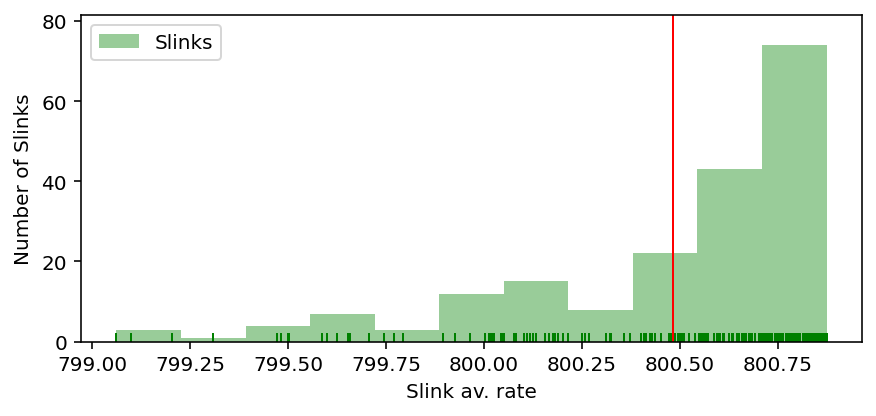

In [25]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1_Swap,L2_Swap):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
#plt.savefig('224 Diff_1st_Swap_2nd_redistribution(just_swap)28fpga_.png')

In [28]:
with open('./16_fpga_threshold_1500_after_swap_S.pkl', mode='wb+') as file:
    cloudpickle.dump(model, file)

In [ ]:
#FIRST SWAP BEFORE BETTER ONE.
#DONT WORK THİS CELL

''''def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=0
        flag=0
        for l in slinkHigh[1][1]:
            #print(l)
            for k in slinkLow[1][1]:
                if abs(float(l[1])-float(k[1]))<dif/2 and abs(float(l[1])-float(k[1]))>temp and float(l[1])>float(k[1]):
                    #print('khmkmh')
                    temp=abs(float(l[1])-float(k[1]))
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==1:
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
                else:
                    continue
            lowC-=1
            print("-------------OK--------------")
        print("-----------------------------")